In [1]:
import numpy as np
np.seterr(invalid='ignore')
import matplotlib.pyplot as plt
import sympy
from sympy import *
print("Using sympy version", sympy.__version__)
from sympy.vector import CoordSys3D
R = CoordSys3D('R')
_x, _y, _z = symbols('x y z')

Using sympy version 1.3


In [2]:
_args = IndexedBase('args')

In [3]:
%matplotlib inline

In [107]:
class Doppler(object):
    
    def __init__(self, field, func, func_ext):
        self.field = field
        self.func = func
        self.func_ext = func_ext
    
    @property
    def field(self):
        return self._field
    
    @field.setter
    def field(self, new_field):
        """
        Differentiate the field to get the vector field
        defining the equipotential lines.
        
        """
        # Update the field
        self._field = new_field
        
        # Compute its derivatives
        f = self._field(R.x, R.y, R.z, _args)
        g = diff(f, R.x) * R.i + diff(f, R.y) * R.j + diff(f, R.z) * R.k
        h = g.cross(R.x * R.i + R.y * R.j + R.z * R.k)
        h /= sqrt(h.dot(R.i) ** 2 + h.dot(R.j) ** 2)
        hx = h.dot(R.i)
        hy = h.dot(R.j)
        dxdt = hx.subs({R.x: _x, R.y: _y, R.z: _z})
        dydt = hy.subs({R.x: _x, R.y: _y, R.z: _z})
        self._dxdt = lambdify((_x, _y, _z, _args), dxdt, "numpy")
        self._dydt = lambdify((_x, _y, _z, _args), dydt, "numpy")
        
    def _dpdt_equip(self, p, args):
        """
        Return the derivative of the vector `p = (x, y, g)`
        with respect to the integration parameter `t`
        along an equipotential line.
        
        """
        x, y, g = p
        r2 = min(1.0, x ** 2 + y ** 2)
        z = np.sqrt(1 - r2)
        dxdt = self._dxdt(x, y, z, args)
        dydt = self._dydt(x, y, z, args)
        G = self.func_ext(x, y, z)
        dgdt = (dxdt * G[0] + dydt * G[1])
        return np.array([dxdt, dydt, dgdt])
    
    def _dpdt_circ(self, p, args):
        """
        Return the derivative of the vector `p = (x, y, g)`
        with respect to the integration parameter `t`
        along the circumference of the disk.
        
        """
        x, y, g = p
        r2 = min(1.0, x ** 2 + y ** 2)
        z = np.sqrt(1 - r2)
        dxdt = -y
        dydt = x
        G = self.func_ext(x, y, z)
        dgdt = (dxdt * G[0] + dydt * G[1])
        return np.array([dxdt, dydt, dgdt])
    
    def _rk4(self, x0, dtau, args, dt=1e-2, maxpts=10000):
        """
        
        """

        p = np.empty((maxpts, 3)) * np.nan
        p[0] = [x0, -np.sqrt(1 - x0 ** 2), 0.0]
        tau_L = self.field(x0, -np.sqrt(1 - x0 ** 2), 0, args)
        
        # DEBUG
        dt = -dt
        
        # Up along the left side
        for n in range(maxpts - 1):
            k1 = dt * self._dpdt_equip(p[n], args)
            k2 = dt * self._dpdt_equip(p[n] + 0.5 * k1, args)
            k3 = dt * self._dpdt_equip(p[n] + 0.5 * k2, args)
            k4 = dt * self._dpdt_equip(p[n] + k3, args)
            new_p = p[n] + (1. / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)
            if new_p[0] ** 2 + new_p[1] ** 2 > 1:
                break
            p[n + 1] = new_p
        
        # Across over the top
        k = n
        for n in range(k, maxpts - 1):
            k1 = dt * self._dpdt_circ(p[n], args)
            k2 = dt * self._dpdt_circ(p[n] + 0.5 * k1, args)
            k3 = dt * self._dpdt_circ(p[n] + 0.5 * k2, args)
            k4 = dt * self._dpdt_circ(p[n] + k3, args)
            new_p = p[n] + (1. / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)
            tau_R = self.field(new_p[0], new_p[1], 0, args)
            if np.abs(tau_R - tau_L) > dtau:
                break
            p[n + 1] = new_p
            
        # Down along the right side
        k = n
        for n in range(k, maxpts - 1):
            k1 = -dt * self._dpdt_equip(p[n], args)
            k2 = -dt * self._dpdt_equip(p[n] + 0.5 * k1, args)
            k3 = -dt * self._dpdt_equip(p[n] + 0.5 * k2, args)
            k4 = -dt * self._dpdt_equip(p[n] + k3, args)
            new_p = p[n] + (1. / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)
            if new_p[0] ** 2 + new_p[1] ** 2 > 1:
                break
            p[n + 1] = new_p
        
        # Across over the bottom
        k = n
        for n in range(k, maxpts - 1):
            k1 = dt * self._dpdt_circ(p[n], args)
            k2 = dt * self._dpdt_circ(p[n] + 0.5 * k1, args)
            k3 = dt * self._dpdt_circ(p[n] + 0.5 * k2, args)
            k4 = dt * self._dpdt_circ(p[n] + k3, args)
            new_p = p[n] + (1. / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)
            tau = self.field(new_p[0], new_p[1], 0, args)
            if not (((tau > tau_L) and (tau < tau_R)) or ((tau > tau_R) and (tau < tau_L))):
                break
            p[n + 1] = new_p

        tau = 0.5 * (tau_L + tau_R)
        x = p[:n + 1, 0]
        y = p[:n + 1, 1]
        g = p[n, 2]
        return tau, g, x, y

In [108]:
def func(x, y, z):
    """
    Some function whose line integral we wish to take.
    In practice, this will be a spherical harmonic.
    
    """
    return 3 * x ** 2 + 0 * z


def func_ext(x, y, z):
    """
    The anti-exterior derivative of `func`.
    
    """
    return np.array([0, x ** 3])


def field(x, y, z, args):
    """
    The Doppler field, whose equipotential lines
    will be the curves along which we integrate
    `func`.
    
    """
    w = args[0]
    sini = args[1]
    cosi = args[2]
    alpha = args[3]
    cb = args[4]
    return w * sini * x * (1 - alpha * (sini * y + cosi * z) ** 2) + z * cb

# Instantiate our Doppler object
D = Doppler(field, func, func_ext)

-0.0011157236032092225 -0.015399055168966112


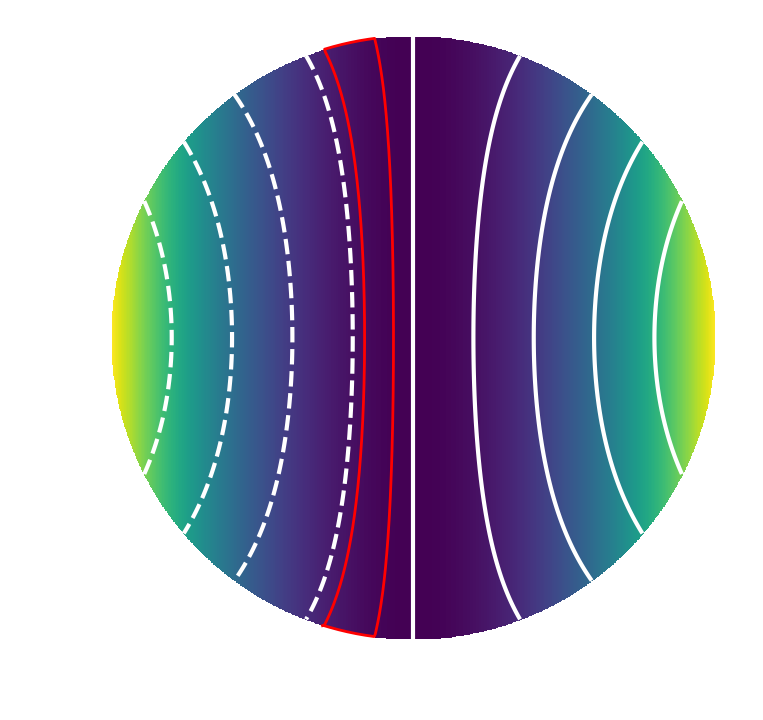

In [109]:
# Field parameters
w = 0.01
i = 90 * np.pi / 180
alpha = 0.5
cb = 0.0
args = [w, np.sin(i), np.cos(i), alpha, cb]

# Plot the image
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(x, y)
z = np.sqrt(1 - x ** 2 - y ** 2)
fig, ax = plt.subplots(1)
ax.imshow(D.func(x, y, z), origin="lower", extent=(-1, 1, -1, 1))
ax.contour(D.field(x, y, z, args), origin="lower", colors="w", extent=(-1, 1, -1, 1), levels=10);
ax.axis('off');

# Compute the line integral using RK4
x0 = -0.3
dtau = 0.001
tau, g, x, y = D._rk4(x0, dtau, args, dt=1e-2)
print(tau, g)
ax.plot(x, y, lw=1, color="r");

In [129]:
# RK4
npts = 100
tau_rk4 = np.zeros(npts)
g_rk4 = np.zeros(npts)
g_rk4_ = np.zeros(npts)
for i, x in enumerate(np.linspace(-1, 1, npts)):
    tau_rk4[i], g_rk4[i], _, _ = D._rk4(x, 0.001, args, dt=1e-3, maxpts=10000)

In [120]:
# Histogram
x = np.linspace(-1, 1, 5000)
y = np.linspace(-1, 1, 5000)
x, y = np.meshgrid(x, y)
inside = x ** 2 + y ** 2 < 1
x = x[inside].flatten()
y = y[inside].flatten()
z = np.sqrt(1 - x ** 2 - y ** 2)
npts = len(x)
tau_h = np.linspace(-0.01, 0.01, 100)
ntau = len(tau_h)
dtau = tau_h[1] - tau_h[0]
bins = np.append(tau_h - 0.5 * dtau, [tau_h[-1] + 0.5 * dtau])
g_h, _ = np.histogram(D.field(x, y, z, args), weights=D.func(x, y, z) * ntau / npts, bins=bins)

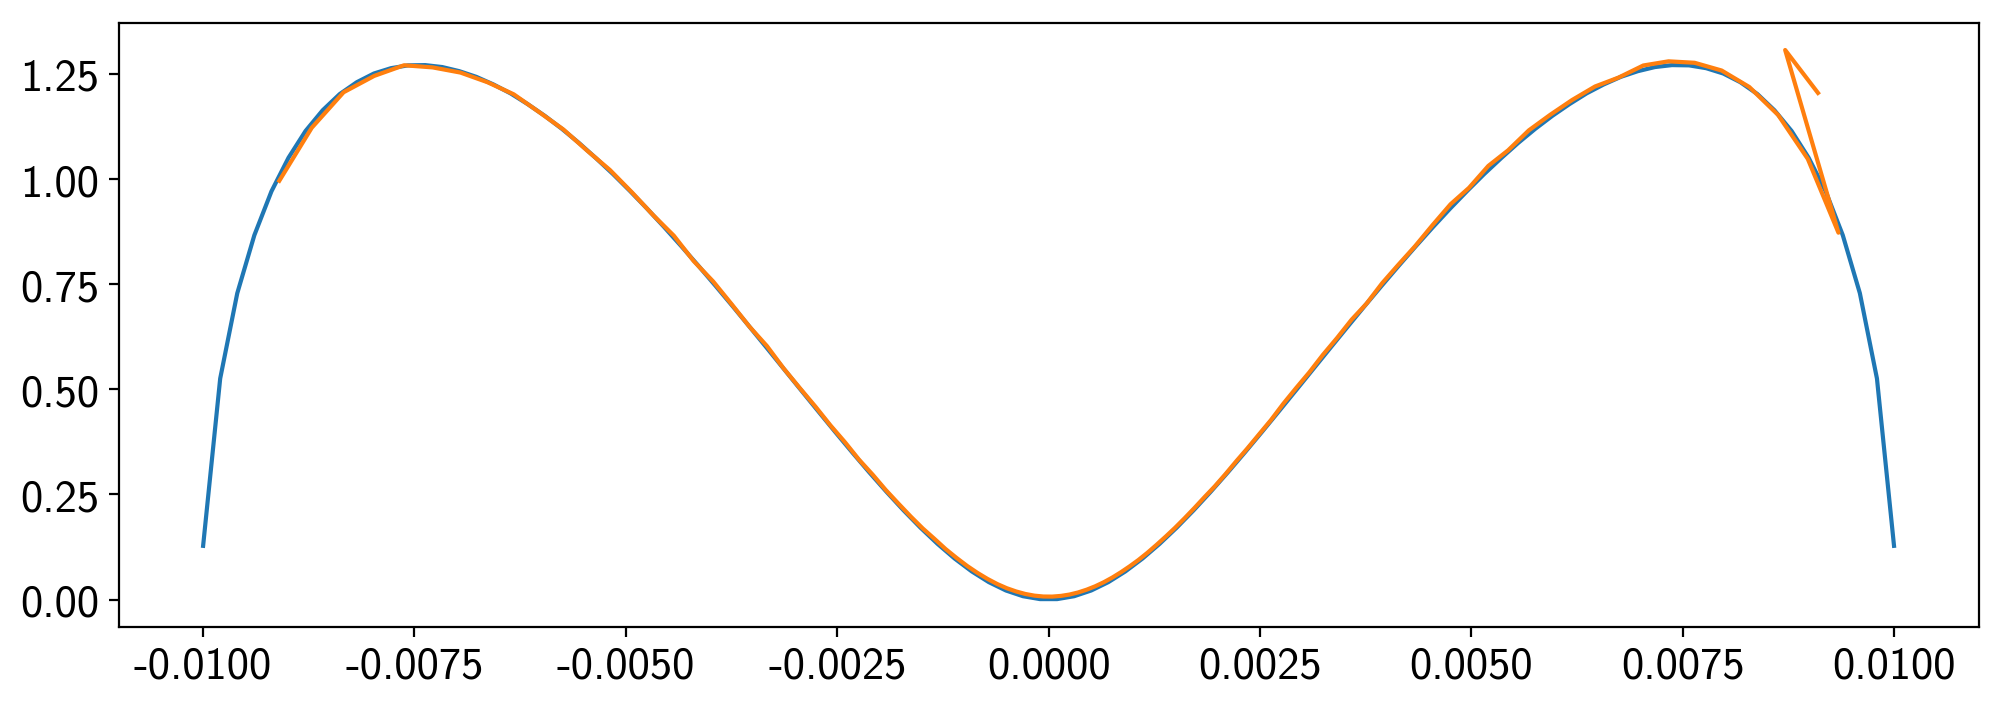

In [134]:
plt.plot(tau_h, g_h);
plt.plot(tau_rk4, -6.5 * g_rk4);